# Predicción de default financiero usando métodos de aprendizaje automático

**Estudiantes**

Federico Ocampo Ortiz, Ing. Sistemas. e-mail: federico.ocampoo@udea.edu.co

Andrés Felipe Orrego Quintero. Ing. Sistemas. e-mail: andres.orrego2@udea.edu.co

**Asesora**

Maria Bernarda Salazar Sánchez, PhD. e-mail: bernarda.salazar@udea.edu.co

## **Líbrerías y funciones**

In [2]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from scipy import stats
import math

#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate


#Escalar Variables
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split # Separación dataset
from sklearn import metrics # Metricas para la evaluación
from sklearn.neighbors import LocalOutlierFactor


In [3]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(20, 10))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=100,ax=ax)
        title_obj = ax.set_title(var_name+" Distribution")
        plt.setp(title_obj, color='black')                     # Individual title colours.

        ax.xaxis.label.set_color('black')  
        ax.yaxis.label.set_color('black')          
        ax.tick_params(axis='x', colors='black')       #set the color of xticks
        ax.tick_params(axis='y', colors='black')       #set the color of yticks
        
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()


In [4]:
#Se crea un dataframe d con los datos obtenidos de archivo de entrada
# TODO: download dataset usign kaggle API
d=pd.read_csv('data/cs-training.csv')

In [5]:
# If you are using kaggle, use this to download dataset in the same folder
import os
os.system('kaggle competitions download -c GiveMeSomeCredit -p ./data')

0

## **Dataset**

In [6]:
#Se crea un dataframe d con los datos obtenidos de archivo de entrada
# TODO: download dataset usign kaggle API
d=pd.read_csv('data/cs-training.csv')
test=pd.read_csv('data/cs-test.csv')
d.head(10)

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
5,6,0,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0
6,7,0,0.305682,57,0,5710.000000,NaN,8,0,3,0,0.0
7,8,0,0.754464,39,0,0.209940,3500.0,8,0,0,0,0.0
8,9,0,0.116951,27,0,46.000000,NaN,2,0,0,0,NaN
9,10,0,0.189169,57,0,0.606291,23684.0,9,0,4,0,2.0


### **Renombrando variables**
<br> Estas especificaciones están contenidas en la Tabla 2 del trabajo de monografía.

In [7]:
# renombramiento de variables
def rename_variables(df):
    return df.rename(
        columns={
            "RevolvingUtilizationOfUnsecuredLines": "TasaUtilizacionLineasRotativas",
            "age": "Edad",
            "NumberOfTime30-59DaysPastDueNotWorse": "Mora30a59dias",
            "DebtRatio": "RazonDeudaMensual",
            "MonthlyIncome": "IngresoMensual",
            "NumberOfOpenCreditLinesAndLoans": "CantidadCreditosActivos",
            "NumberOfTimes90DaysLate": "MoraMayorA90",
            "NumberRealEstateLoansOrLines": "CantidadCreditosDeVivienda",
            "NumberOfTime60-89DaysPastDueNotWorse": "Mora60a89dias",
            "NumberOfDependents": "CantidadDependientes",
            "SeriousDlqin2yrs": "Incumplimiento"
        }
    )
d = rename_variables(d)
test = rename_variables(test)

La primera columna de los datos de entrenamiento y validación identificada como `Unnamed: 0` corresponde a un identificador de fila que no aporta valor al modelo, por lo tanto se elimina.

In [8]:
#Borrando columnas que no se emplearán
d.drop(['Unnamed: 0'], axis='columns', inplace=True)

Se encuentra un único registro con `Edad` igual a cero el cual es eliminado. Los valores desconocidos de `Ingreso Mensual` son remplazados por la media. Por último los valores nulos de `Dependientes` son imputados con la media de la característica.

In [9]:
d = d[d['Edad'] != 0]
d["IngresoMensual"] = d["IngresoMensual"].replace(np.nan, d["IngresoMensual"].median())
d["CantidadDependientes"].fillna(d["CantidadDependientes"].median(), inplace=True)

**Dimensiones y tipos de variables**

In [10]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149999 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Incumplimiento                  149999 non-null  int64  
 1   TasaUtilizacionLineasRotativas  149999 non-null  float64
 2   Edad                            149999 non-null  int64  
 3   Mora30a59dias                   149999 non-null  int64  
 4   RazonDeudaMensual               149999 non-null  float64
 5   IngresoMensual                  149999 non-null  float64
 6   CantidadCreditosActivos         149999 non-null  int64  
 7   MoraMayorA90                    149999 non-null  int64  
 8   CantidadCreditosDeVivienda      149999 non-null  int64  
 9   Mora60a89dias                   149999 non-null  int64  
 10  CantidadDependientes            149999 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 13.7 MB


In [11]:
d.describe()

,Incumplimiento,TasaUtilizacionLineasRotativas,Edad,Mora30a59dias,RazonDeudaMensual,IngresoMensual,CantidadCreditosActivos,MoraMayorA90,CantidadCreditosDeVivienda,Mora60a89dias,CantidadDependientes
count,149999.000000,149999.000000,149999.000000,149999.000000,149999.000000,1.499990e+05,149999.000000,149999.000000,149999.000000,149999.000000,149999.000000
mean,0.066840,6.048472,52.295555,0.421029,353.007426,6.418458e+03,8.452776,0.265975,1.018233,0.240388,0.737405
std,0.249746,249.756203,14.771298,4.192795,2037.825113,1.289044e+04,5.145964,4.169318,1.129772,4.155193,1.107020
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.903000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154176,52.000000,0.000000,0.366503,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559044,63.000000,0.000000,0.868257,7.400000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


**Histogramas**
<br> La base de datos contiene información de población entre los 20 y 80 años (distribución gausiana) con 0 personas a cargo (dependientes) en su gran mayoría, los cuales adquieren más de 2 créditos de forma simultánea (campana a la izquierda `LineasCredito`)

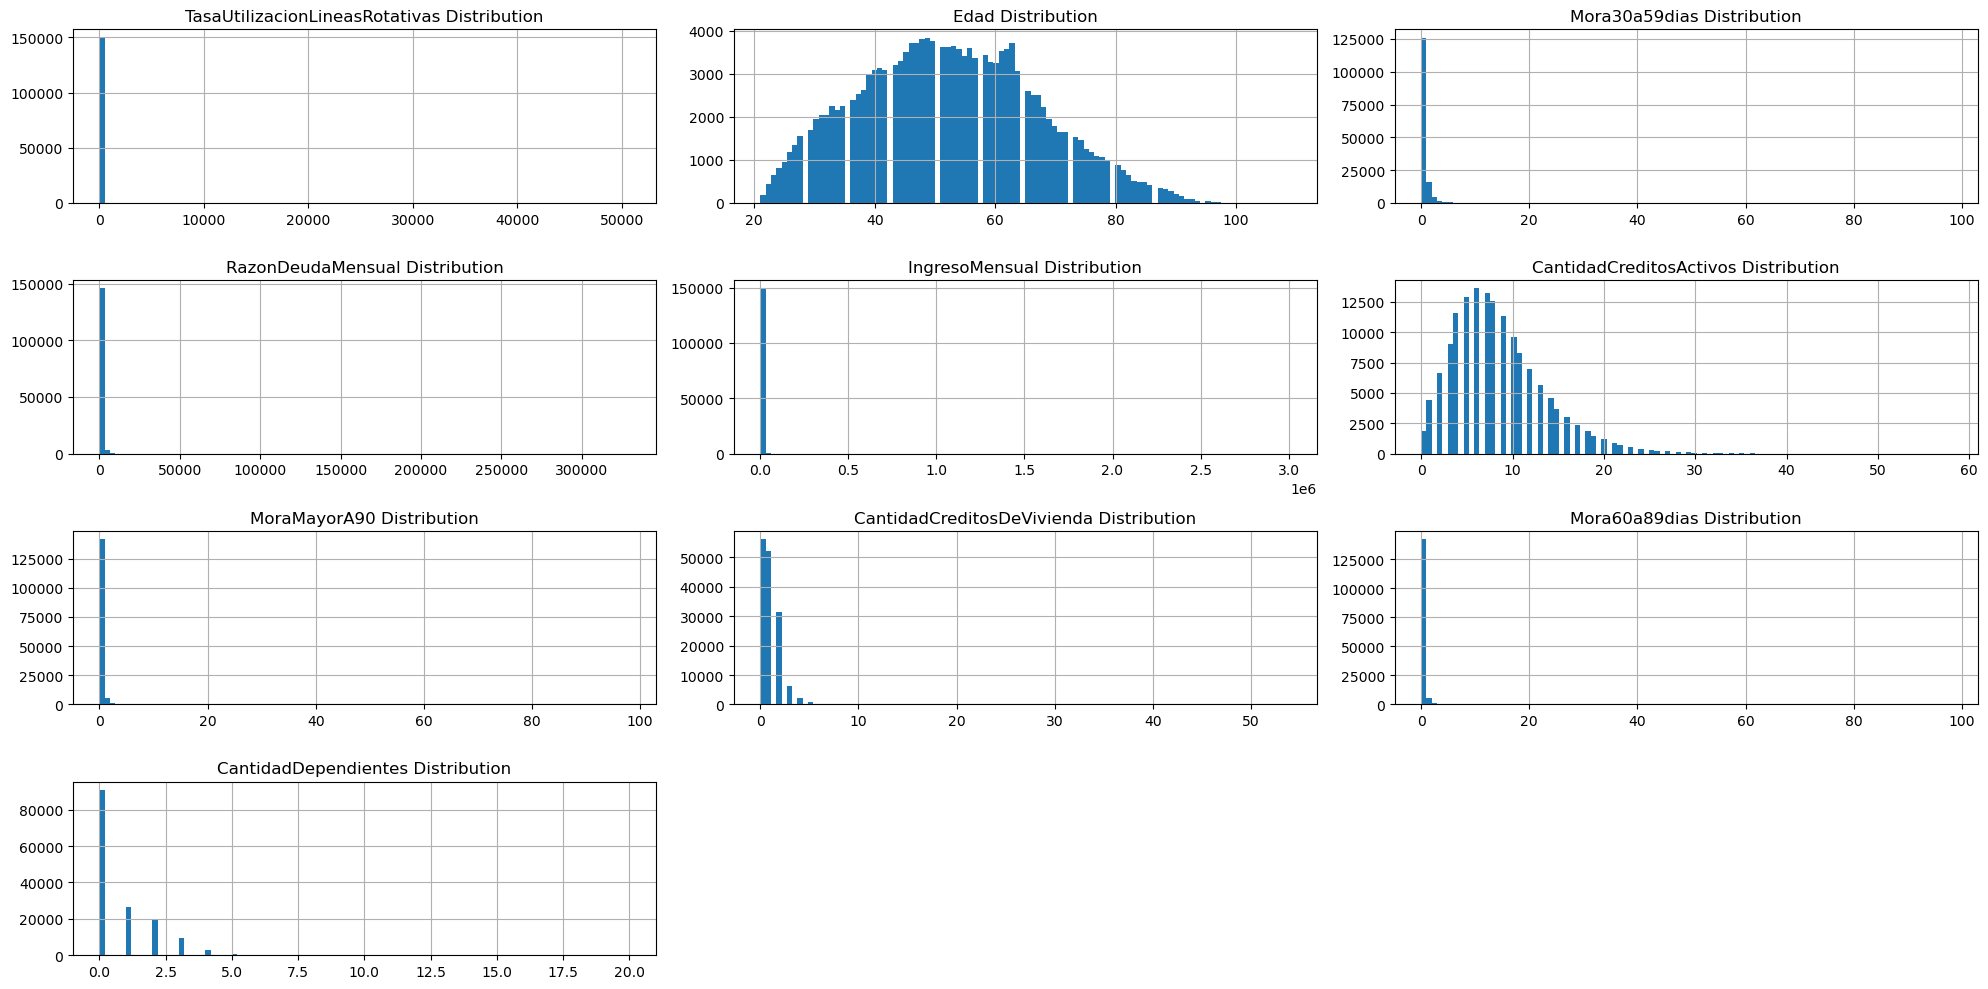

In [12]:
#Lista de variables numéricas
features = d.columns.tolist()
features.remove('Incumplimiento')

# filter d only with numCols columns
draw_histograms(d[features], d[features].columns, 4, 3)

A continuación se realiza un histograma para cada variable del dataset de prueba, con el fin de identificar la distribución de los datos y la presencia de valores atípicos. Esto también sirve para comparar la distribución de los datos de entrenamiento y validación para cada variable.

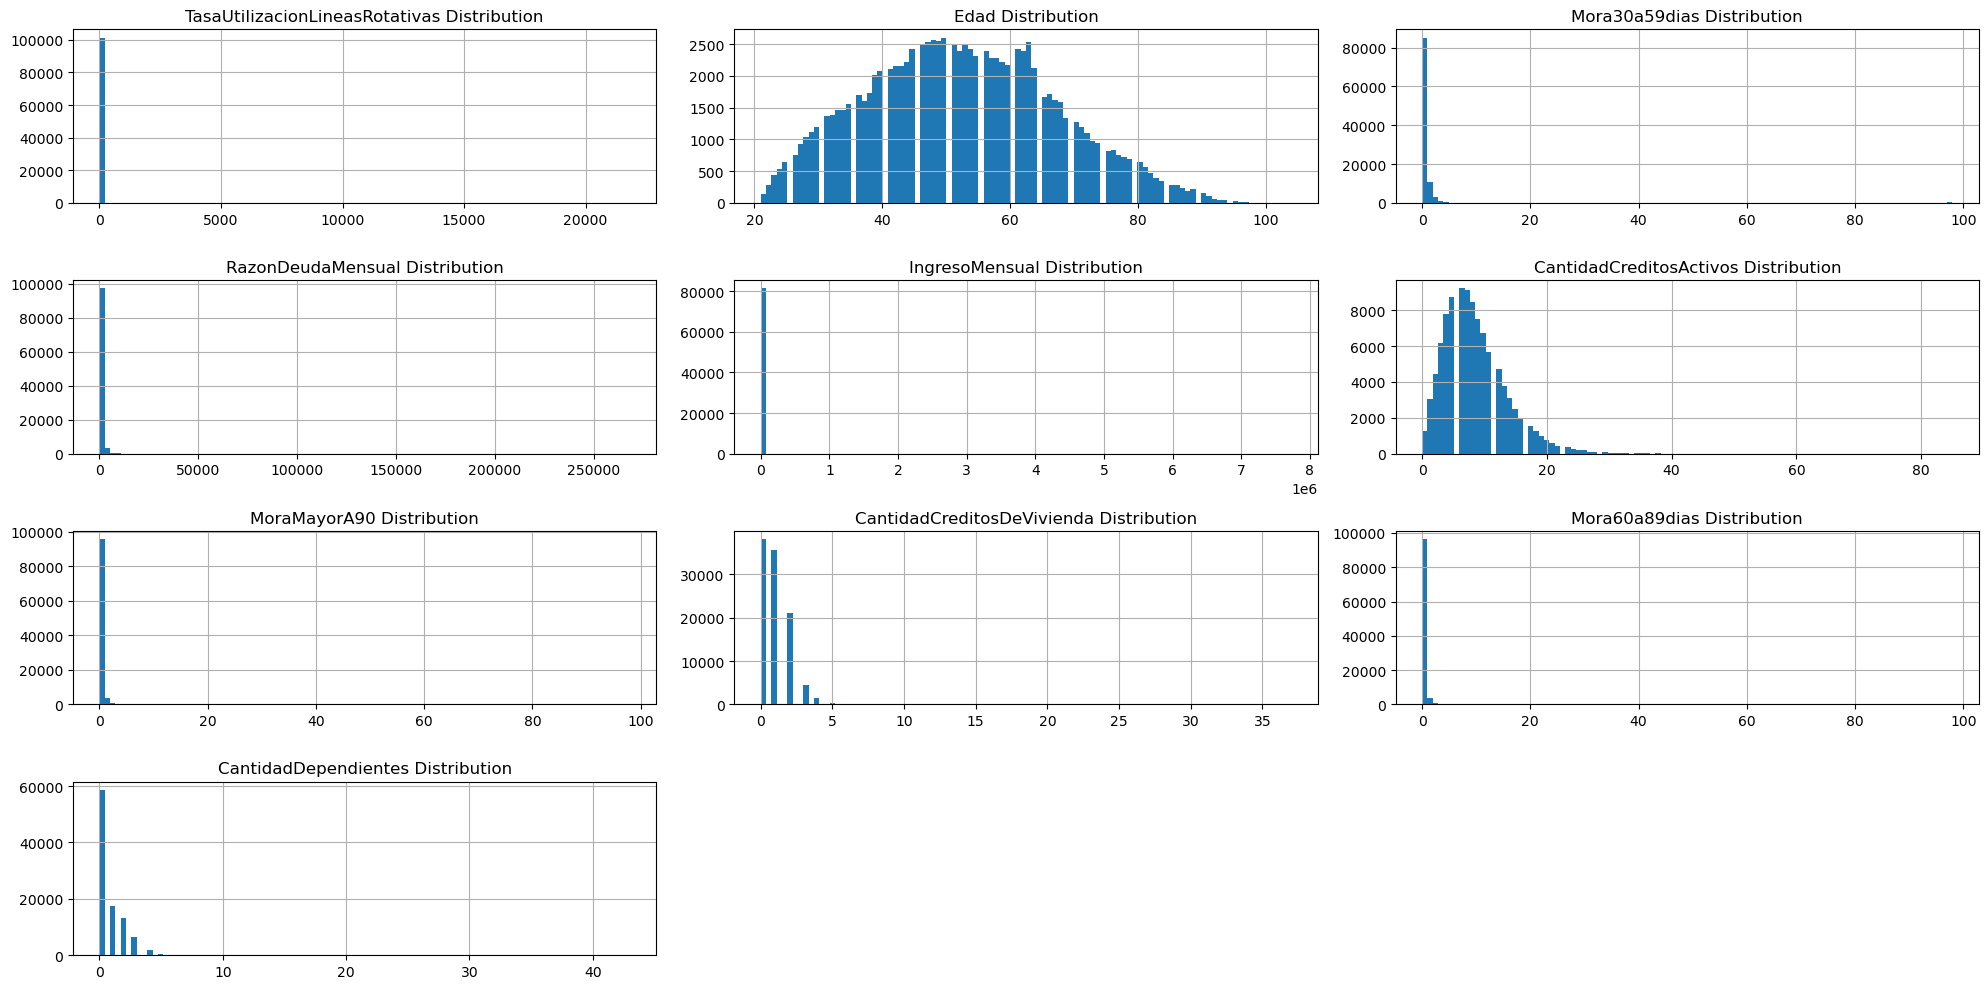

In [13]:
draw_histograms(test[features], test[features].columns, 4, 3)

### **Análisis de la relación lineal entre las variables**

OJOJOJOJOJ Falta escribir algo aquí sobre lo que se verá en la matriz

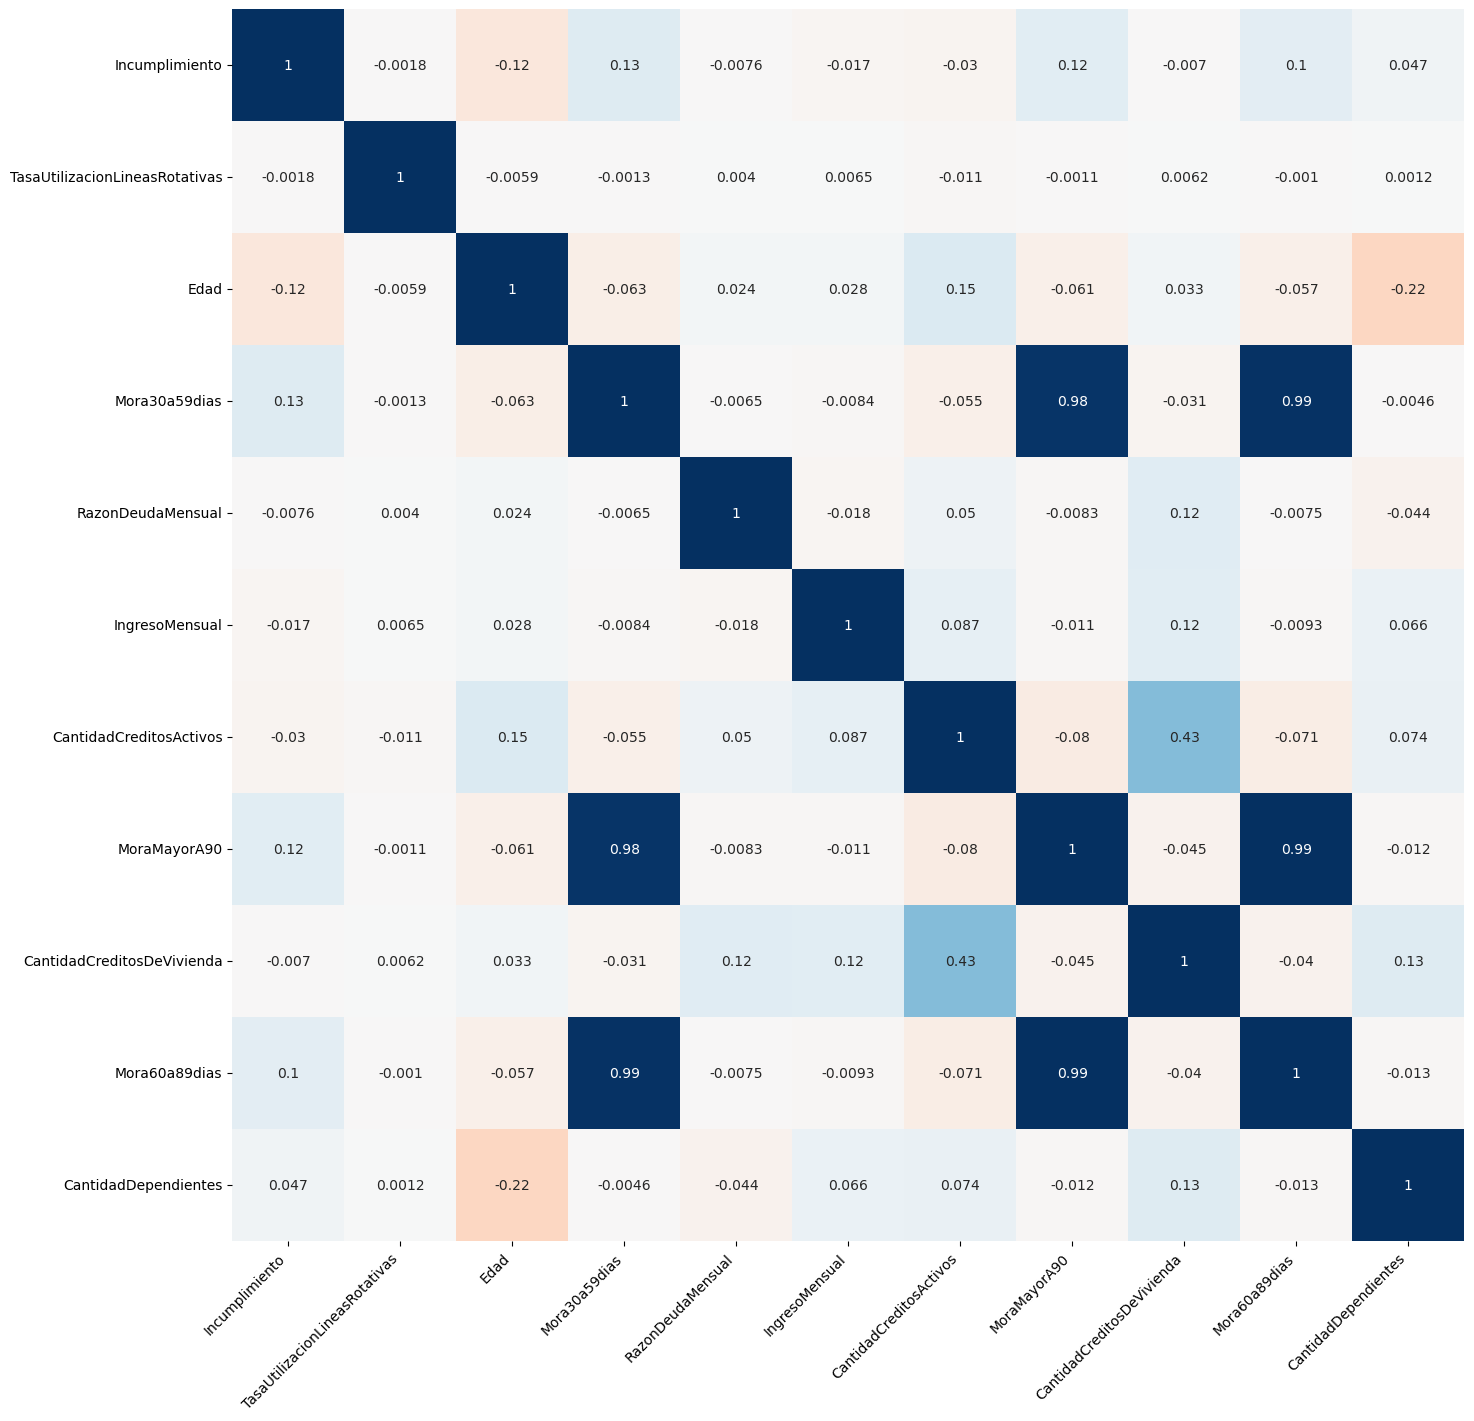

In [14]:
#Matriz de correlación
matrizCorr = d.corr()
# Mapa de calor (Heatmap) de la matriz de correlaciones
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(26, 16))

sns.heatmap(
    matrizCorr,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 10},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = 'RdBu', #sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

## **Detección de atípicos**

In [15]:
def plot_histograms_variables(var):
    # subplots to graph boxplots of variable TasaUtilizacionLineasRotativas
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))

    sns.boxplot(
        x    = d[var],
        ax   = ax[0],
        color = 'blue'
    )

    ax[0].set_xlabel(
        var+' (train)',
        fontsize = 10,
    )

    ax[0].tick_params(labelsize = 10)
    sns.boxplot(
        x    = test[var],
        ax   = ax[1],
        color = 'blue'
    )

    ax[1].set_xlabel(
        var+' (test)',
        fontsize = 10,
    )

    ax[1].tick_params(labelsize = 10)


    fig.tight_layout()

### TasaUtilizacionLineasRotativas

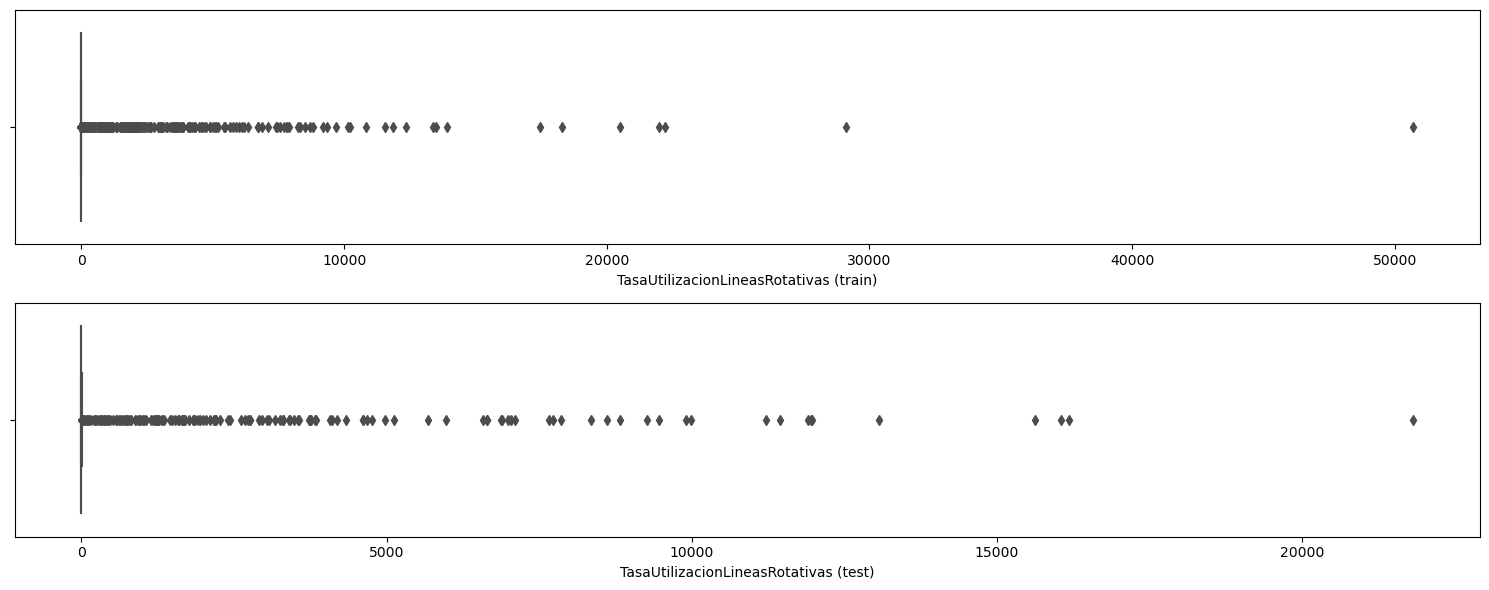

In [16]:
#histplot de la variable TasaUtilizacionLineasRotativas
plot_histograms_variables('TasaUtilizacionLineasRotativas')

In [39]:
d["TasaUtilizacionLineasRotativas"].describe()


count    101503.000000
mean          5.310000
std         196.156039
min           0.000000
25%           0.030131
50%           0.152586
75%           0.564225
max       21821.000000
Name: TasaUtilizacionLineasRotativas, dtype: float64

In [40]:
test["TasaUtilizacionLineasRotativas"].describe()

count    101503.000000
mean          5.310000
std         196.156039
min           0.000000
25%           0.030131
50%           0.152586
75%           0.564225
max       21821.000000
Name: TasaUtilizacionLineasRotativas, dtype: float64

In [44]:
print(f"Valores por encima de 1 en datos de entrenamiento: {d[d['TasaUtilizacionLineasRotativas'] > 1].shape[0]}")
print(f"Valores por encima de 1 en datos de validación: {test[test['TasaUtilizacionLineasRotativas'] > 1].shape[0]}")

Valores por encima de 1 en datos de entrenamiento: 3321
Valores por encima de 1 en datos de validación: 2181


La variable `TasaUtilizacionLineasRotativas` muestra el balance total de las tarjetas de crédito y lineas personales de crédito dividido por los cupos de estos créditos. Esto quiere decir que si una persona tiene $100 de cupo y usa $30, tendrá entonces una Tasa de utilización del 0.3. Se entiende entonces que corresponde a un porcentaje cuyos valores validos son de 0 a 1. 

Analizando los datos se encuentran valores por encima de 1, lo que no concuerda con el entendimiento de la variable. La conclusión inicial sería eliminar estos datos para evitar sesgos en los resultados, sin embargo también se evidencia el mismo comportamiento en el conjunto de datos de validación. Esto conllevaria a eliminar datos del conjunto de validación y así no se podrían cargar los resultados en kaggle para verificar la precisión del modelo. 

Por ahora estos valores se dejan así y se continua con el analísis de las variables.

### Variables ocurrencias de mora

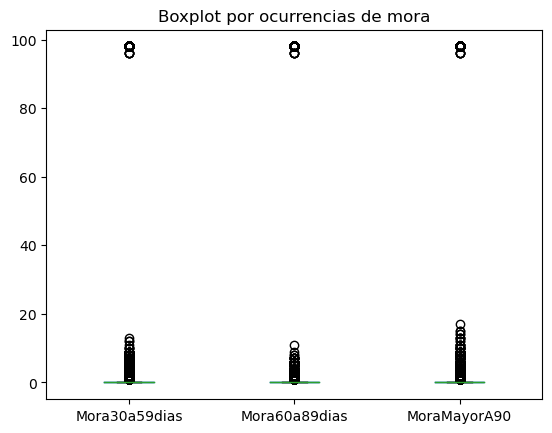

In [73]:
green_diamond = dict(markerfacecolor='g', marker='D')
fig, ax = plt.subplots()
ax.set_title('Boxplot por ocurrencias de mora')
ax.boxplot = d.boxplot(column=['Mora30a59dias', 'Mora60a89dias', 'MoraMayorA90'], grid=False)  

**Distribución en datos de validacion**

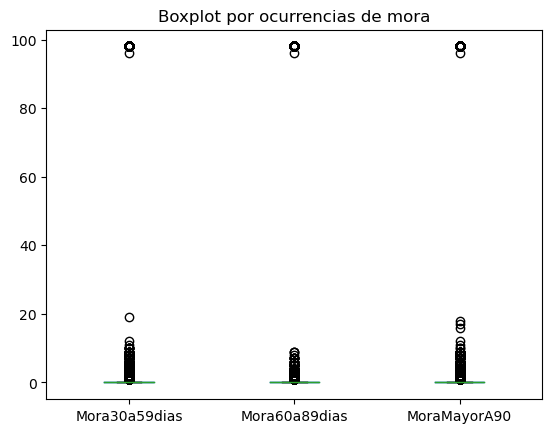

In [13]:
green_diamond = dict(markerfacecolor='g', marker='D')
fig, ax = plt.subplots()
ax.set_title('Boxplot por ocurrencias de mora')
ax.boxplot = test.boxplot(column=['Mora30a59dias', 'Mora60a89dias', 'MoraMayorA90'], grid=False)  

**Análisis de distribución de las variables categóricas para una ventana de dos años (730 días)**. Se definen como valores atípicos para esta ventana de tiempo registros cuyo valor sea superior a:
* 25 ocurrencias de mora en la ventana de 30 a 59 días
* 13 ocurrencias de mora en la ventana de 60 a 89 días

In [74]:
days_in_two_years = 365 * 2
max_possible_mora30_59 = math.ceil(days_in_two_years / 30)
print(f"Maximum value for Mora30a59: {max_possible_mora30_59}")

max_possible_mora60_89 = math.ceil(days_in_two_years / 60)
print(f"Maximum value for Mora60a89: {max_possible_mora60_89}")

print(f"Instances with Mora30a59 > {max_possible_mora30_59}: {len(d[d['Mora30a59dias'] > max_possible_mora30_59])}" )
print(f"Instances with Mora60a89 > {max_possible_mora60_89}: {len(d[d['Mora60a89dias'] > max_possible_mora60_89])}" )

Maximum value for Mora30a59: 25
Maximum value for Mora60a89: 13
Instances with Mora30a59 > 25: 269
Instances with Mora60a89 > 13: 269


Se encuentran entonces 269 valores atípicos para los variables `Mora30a59dias` y `Mora60a89dias`. De igual manera al revisar el conjunto de validación se evidencia el mismo escenario. Si estos valores atípicos se eliminan del conjunto de entrenamiento, entonces el modelo no tendra la capacidad para predecir en estos casos, lo que puede provocar un sesgo y perdida de precisión en el modelo. Por esta razón, se decide mantener estos datos atípicos para las variables de ocurrencia de mora.

In [75]:
# TODO: Antes de eliminar tener en cuenta distribución en test
print(f"length of dataset before deleting {len(d)}")
# d = d[(d['Mora30a59dias'] <= max_possible_mora30_59) & (d['Mora60a89dias'] <= max_possible_mora60_89)]
print(f"length of dataset after deleting {len(d)}")

length of dataset before deleting 150000
length of dataset after deleting 149731


### Edad

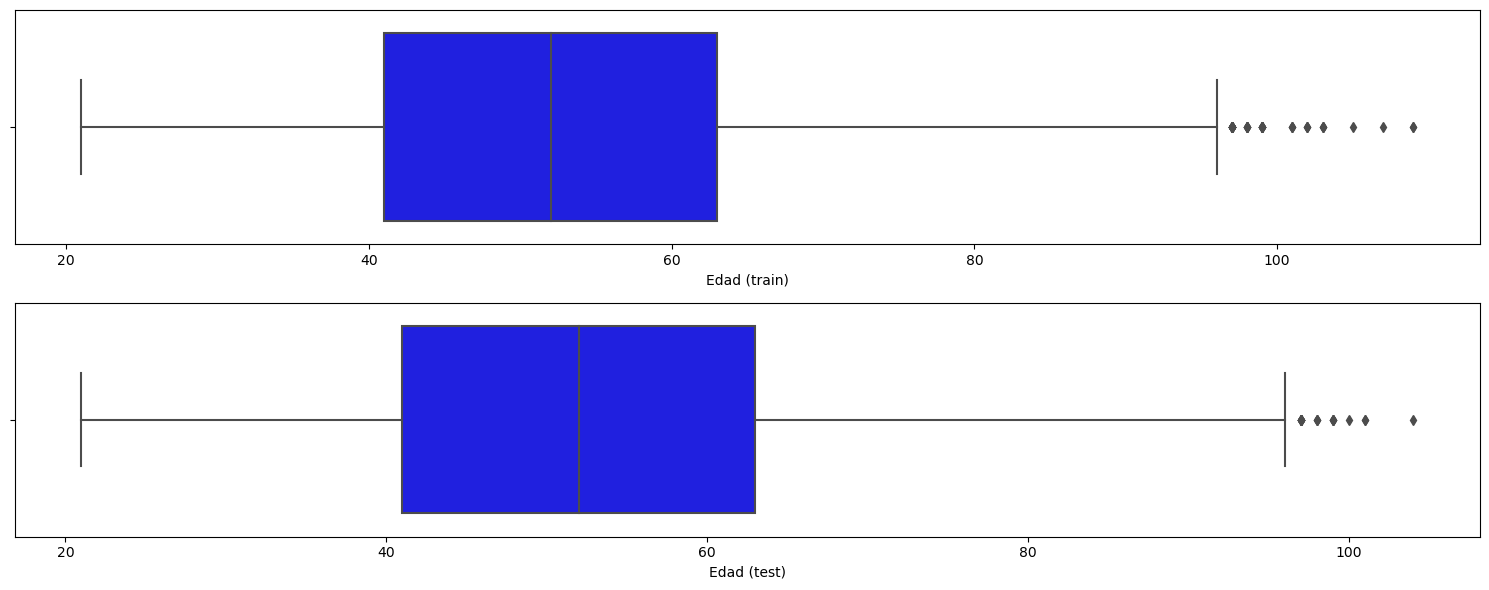

In [17]:
plot_histograms_variables("Edad")

In [18]:
d["Edad"].describe()

count    149999.000000
mean         52.295555
std          14.771298
min          21.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: Edad, dtype: float64

In [19]:
test["Edad"].describe()

count    101503.000000
mean         52.405436
std          14.779756
min          21.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         104.000000
Name: Edad, dtype: float64

En el caso de la variable `Edad` los valores obtenidos son razonables y no es necesario realizar algún preprocesamiento adicional. Anteriormente se había eliminido un único registro en el conjunto de entrenamiento con Edad cero.

### RazonDeudaMensual

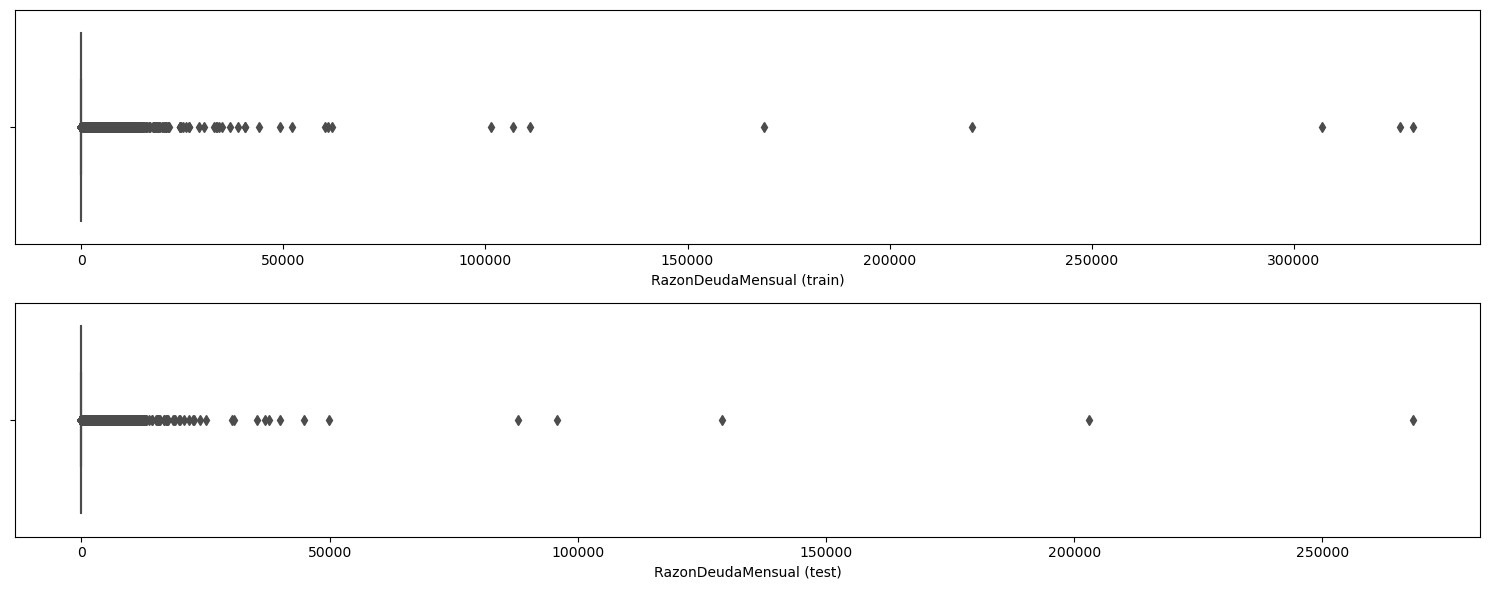

In [20]:
plot_histograms_variables("RazonDeudaMensual")

In [21]:
d["RazonDeudaMensual"].describe()

count    149999.000000
mean        353.007426
std        2037.825113
min           0.000000
25%           0.175074
50%           0.366503
75%           0.868257
max      329664.000000
Name: RazonDeudaMensual, dtype: float64

In [22]:
test["RazonDeudaMensual"].describe()

count    101503.000000
mean        344.475020
std        1632.595231
min           0.000000
25%           0.173423
50%           0.364260
75%           0.851619
max      268326.000000
Name: RazonDeudaMensual, dtype: float64

Para la variable `RazonDeudaMensual` se encuentran valores atípicos por encima de 1, que no corresponden con el tipo de dato de esta variable, que es porcentaje. En este caso un valor por encima de 1 (100%) indicaría que las deudas están por encima de los ingresos percibidos mensualmente, lo cual puede ser posible y puede representar una persona con alto riesgo de incumplimiento en el pago de sus obligaciones. Ahora esto puede ser cierto pero dependiendo del rango de los valores que tome esta variable. Si se tiene una razón de deuda mensual de 300.000, que es el máximo valor para el conjunto de entrenamiento; se estaría hablando de unas deudas mensuales equivalentes a 300.000 veces el ingreso mensual, lo cual no sería muy probable en la vida real; en caso de que ocurriese estaríamos nuevamente frente a un caso de una persona con alto riesgo de incumplimiento. 

Estos valores aunque son irreales y pueden deberse a errores en la imputación, se mantienen por las mismas razón esbozadas anteriormente; el conjunto de validación cuenta con las mismas distribuciones y presencia de datos atípicos, y una eliminación o procesamiento de estos registros conllevaria a disminuir el conjunto de validación y entonces el reto no podría ser subido a kaggle. Esperaremos hasta la etapa de modelamiento para decidir si se deben eliminar estas variables o no.

### CantidadDependientes

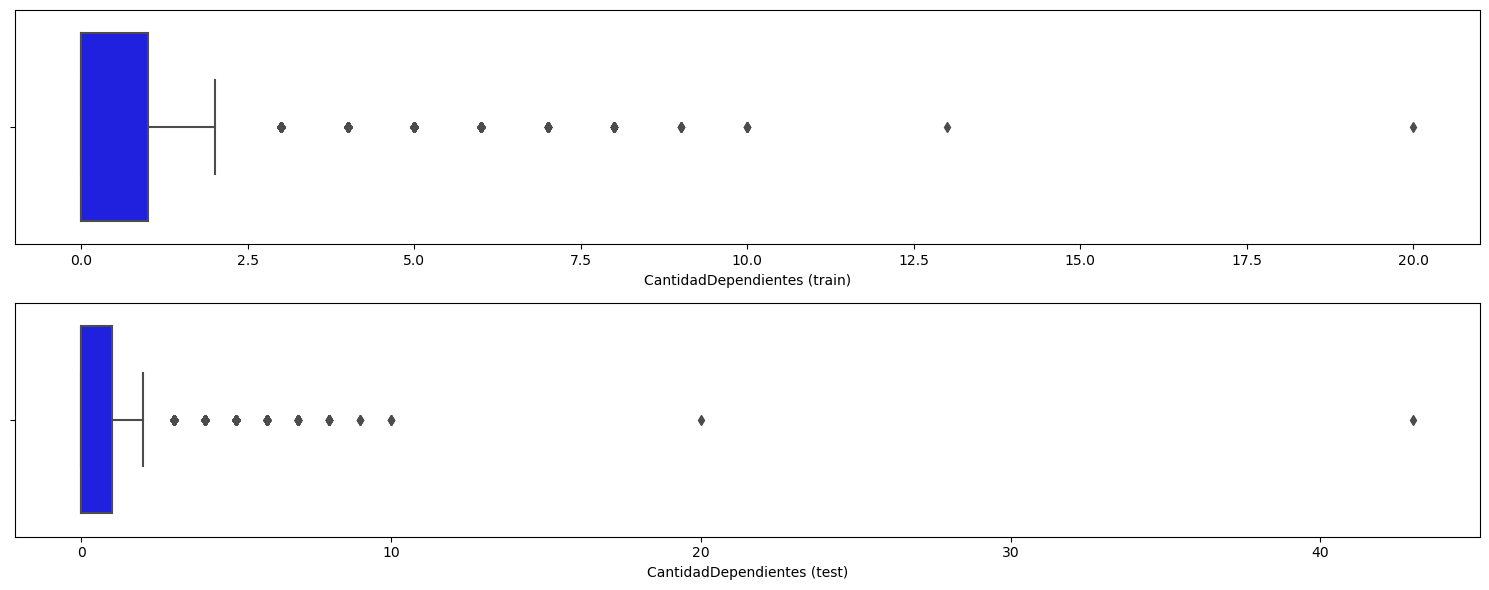

In [23]:
plot_histograms_variables("CantidadDependientes")

El número de dependientes también tiene algunos valores atípicos en ambos conjuntos de datos. Tener 20 o más de 40 personas dependientes no es un caso que pueda verse en la vida real. Sin embargo, estos valores se mantienen por las mismas razones expuestas anteriormente.

### IngresaMensual

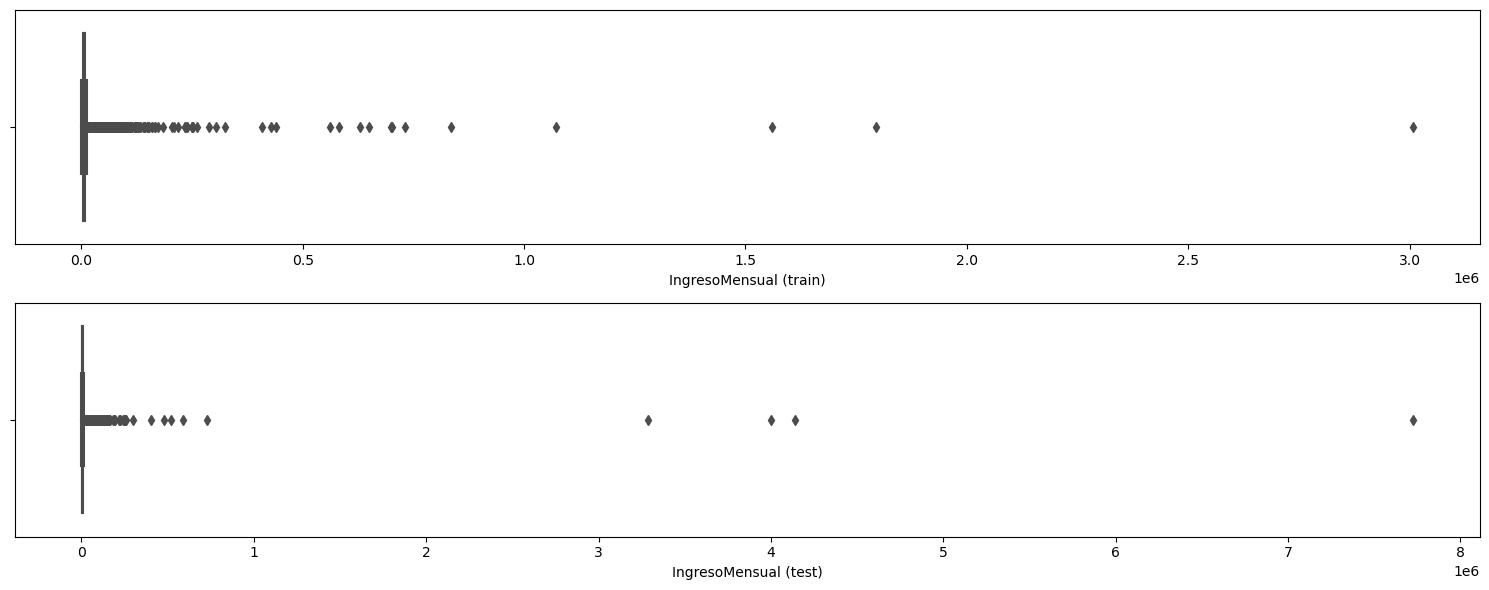

In [25]:
plot_histograms_variables("IngresoMensual")

In [28]:
# describe without cientific notation
pd.options.display.float_format = '{:.2f}'.format
d["IngresoMensual"].describe()

count    149999.00
mean       6418.46
std       12890.44
min           0.00
25%        3903.00
50%        5400.00
75%        7400.00
max     3008750.00
Name: IngresoMensual, dtype: float64

In [29]:
test["IngresoMensual"].describe()

count     81400.00
mean       6855.04
std       36508.60
min           0.00
25%        3408.00
50%        5400.00
75%        8200.00
max     7727000.00
Name: IngresoMensual, dtype: float64

El 75% de los datos para la variable `IngresoMensual` en ambos conjuntos de datos se encuentran por debajo de $10.000, lo que es un comportamiento normal. Se encuentran algunos valores atípicos como el máximo de $3.008.750 en el conjunto de entrenamiento, que es un ingreso mensual demasiado elevado y poco probable para el contexto que estamos trabajando; no tendría mucho sentido que una persona con estos ingresos mensuales tenga deudas o necesite créditos. En el conjunto de validación se encuentra un valor maximo de $7.727.000 que también es muy elevado. 
<br> Con todo esto, se decide mantener estos valores para no restarle poder predictivo al modelo.

### CantidadCreditosDeVivienda

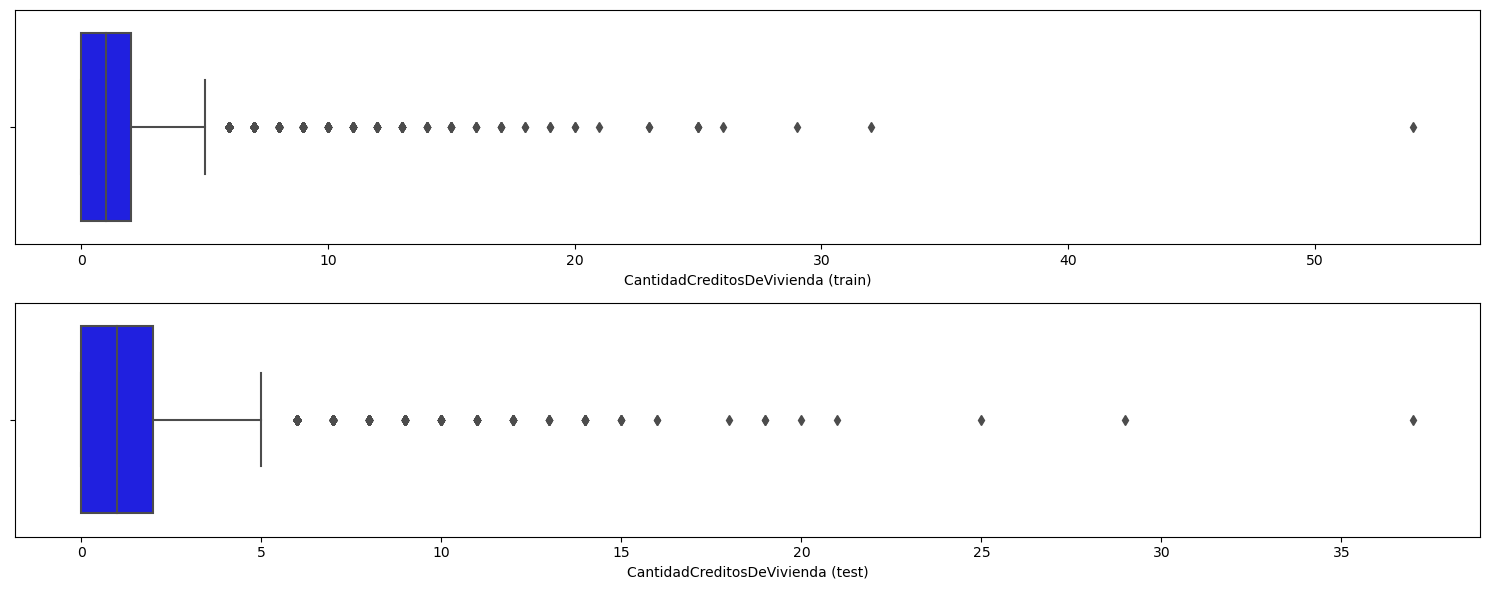

In [30]:
plot_histograms_variables("CantidadCreditosDeVivienda")

In [31]:
d["CantidadCreditosDeVivienda"].describe()

count   149999.00
mean         1.02
std          1.13
min          0.00
25%          0.00
50%          1.00
75%          2.00
max         54.00
Name: CantidadCreditosDeVivienda, dtype: float64

In [32]:
test["CantidadCreditosDeVivienda"].describe()

count   101503.00
mean         1.01
std          1.11
min          0.00
25%          0.00
50%          1.00
75%          2.00
max         37.00
Name: CantidadCreditosDeVivienda, dtype: float64

Para la variable `CantidadCreditosDeVivienda` , que incluye la cantidad de créditos de hipoteca y lineas de crédito de vivienda, se encuentra que el 75% de los datos están dentro de los rangos esperados para esta variable. Se encuentran datos muy elevados y atípicos como 54 o 37 créditos de vivienda para una persona, lo cual no es muy probable que suceda en la vida real. Es importante resaltar que esta variable habla de la cantidad de créditos y no si los créditos están activos o vigentes, esto quiere decir que se pueda estar contando créditos ya cancelados. 

### CantidadCreditosActivos

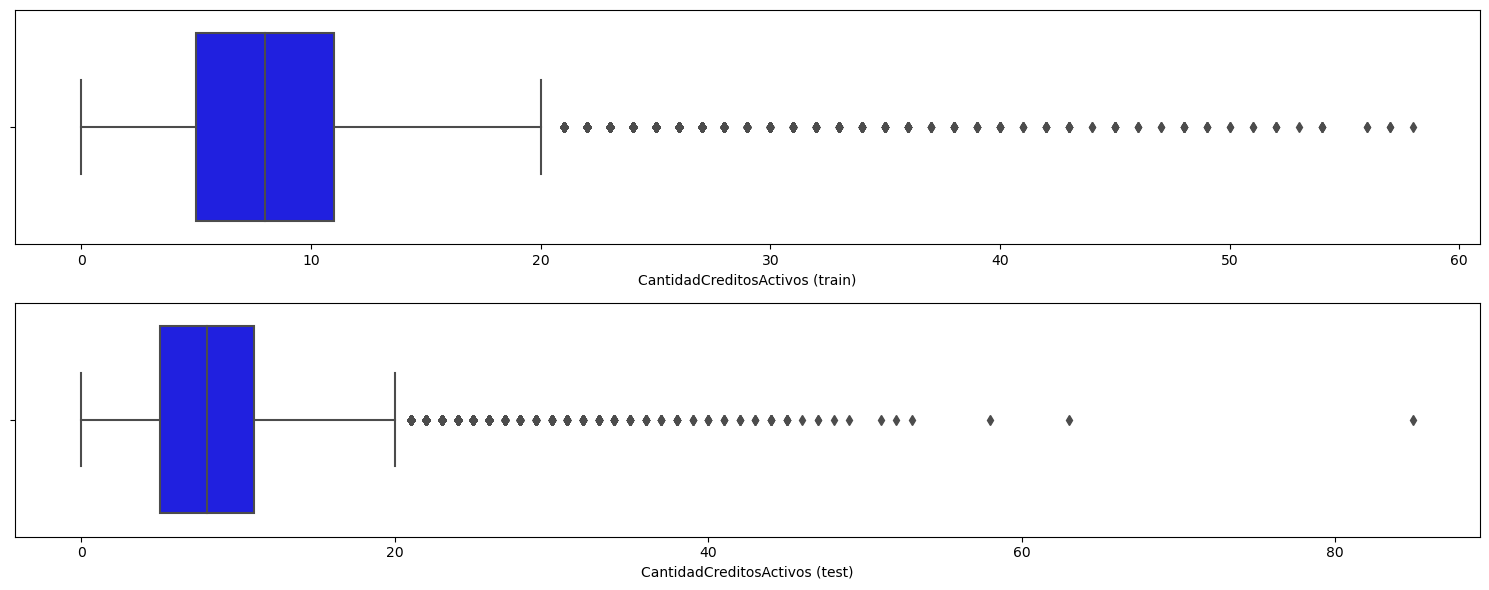

In [33]:
plot_histograms_variables("CantidadCreditosActivos")

In [34]:
d["CantidadCreditosActivos"].describe()

count   149999.00
mean         8.45
std          5.15
min          0.00
25%          5.00
50%          8.00
75%         11.00
max         58.00
Name: CantidadCreditosActivos, dtype: float64

In [35]:
test["CantidadCreditosActivos"].describe()

count   101503.00
mean         8.45
std          5.14
min          0.00
25%          5.00
50%          8.00
75%         11.00
max         85.00
Name: CantidadCreditosActivos, dtype: float64

Esta variable también presenta datos atípicos sin embargo se mantienen para la ejecución del modelo. 

### Conclusiones
- En esta revisión inicial de los datos se encuentra que casí todas las variables presentan datos atípicos. 
- Estos datos atípicos se presentan tanto en el conjunto de entrenamiento como el de validación.
- Sí se eliminan estos datos atípicos se disminuye el conjunto de validación y no se podría subir el reto a kaggle. También se podría perder poder predictivo del modelo.
- Inicialmente se van a mantener estos datos, y esperar los resultados del modelo para tomar decisiones de imputación o eliminación.

Cálculo de la **nueva variable** `OcurrenciasMora`
<br>Esta variable es la suma de las ocurrencias de mora en las ventanas de 30 a 59 días, 60 a 89 días y mayor a 90 días para cada registro.

In [76]:
# calculate new variable with the number of moras
d['OcurrenciasMora'] = d['Mora30a59dias'] + d['Mora60a89dias'] + d['MoraMayorA90']

d['OcurrenciasMora'].describe()

count    149731.000000
mean          0.401073
std           1.102147
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          19.000000
Name: OcurrenciasMora, dtype: float64

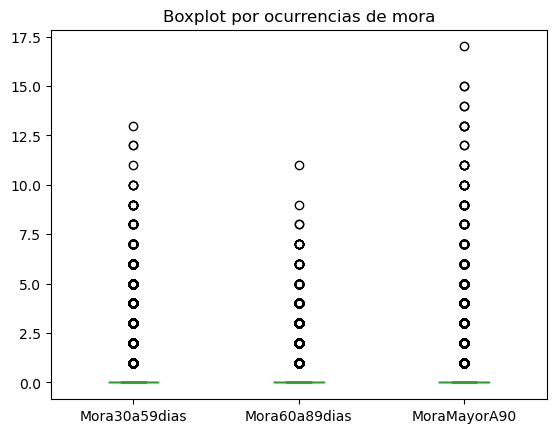

In [77]:
green_diamond = dict(markerfacecolor='g', marker='D')
fig, ax = plt.subplots()
ax.set_title('Boxplot por ocurrencias de mora')
ax.boxplot = d.boxplot(column=['Mora30a59dias', 'Mora60a89dias', 'MoraMayorA90'], grid=False)  

Análisis de la relación lineal **POS eliminación de atípicos ocurrencias por mora**

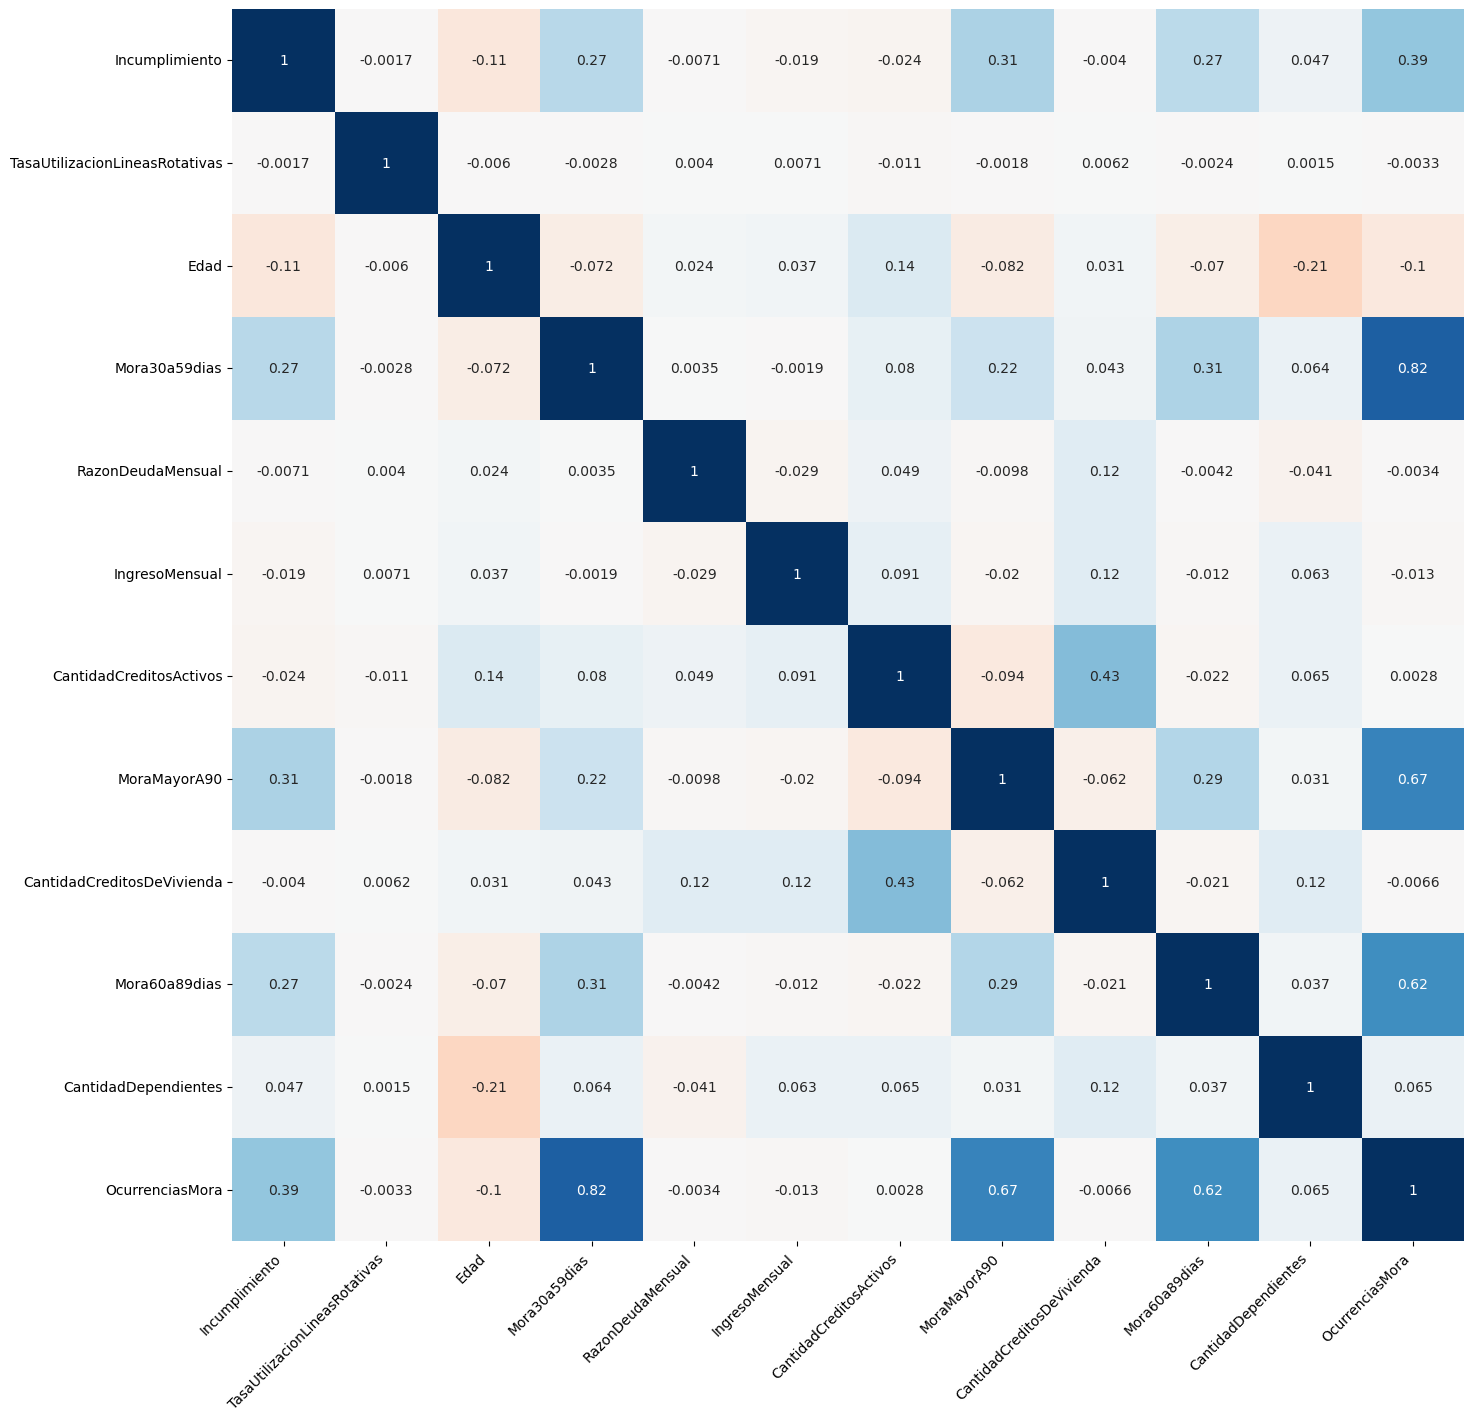

In [78]:
#Matriz de correlación
matrizCorr = d.corr()
# Mapa de calor (Heatmap) de la matriz de correlaciones
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(26, 16))

sns.heatmap(
    matrizCorr,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 10},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = 'RdBu', #sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

Al eliminar los valores atípicos de las variables temporales `Mora30a59dias` y `Mora60a89dias` se puede observar como se redefine la relación lineal entre las variables, pasando de ~0.98 a ~0.20. Sin embargo, se sigue evidenciando que estas variables tienen una correlación más alta en comparación con las demás variables en la base de datos.
<br> También se puede evidenciar que en general las variables analizadas no están directamente correlacionadas con la variable de interés para la clasificación (`Incumplimiento`), se obtienen valores de correlación menores a 0.31 en todos los casos.

### **Atípicos utilizando LOF**

Eliminación de valores atípicos utilizando el método Detección de valores atípicos con Local Outlier Factor [(LOF)](https://qu4nt.github.io/sklearn-doc-es/auto_examples/neighbors/plot_lof_outlier_detection.html). La puntuación de anomalía de cada muestra se denomina Factor de Anomalía Local. Mide la desviación local de la densidad de una muestra dada con respecto a sus vecinos. Es local en el sentido de que el valor de la anomalía depende de lo aislado que esté el objeto con respecto al vecindario circundante. Más concretamente, la localidad viene dada por los k vecinos más cercanos, cuya distancia se utiliza para estimar la densidad local. Comparando la densidad local de una muestra con las densidades locales de sus vecinos, se pueden identificar las muestras que tienen una densidad sustancialmente menor que sus vecinos. Estas se consideran valores atípicos.

In [19]:
# crear un objeto LocalOutlierFactor con n_neighbors=14
lof = LocalOutlierFactor(n_neighbors=2, algorithm='auto', contamination='auto', metric='euclidean')

y_pred = lof.fit_predict(d[features])
ground_truth = np.ones(len(d[features]), dtype=int)
outliers = y_pred != ground_truth
#outliers = y_pred == -1
print(f"Valores atípicos detectados: { (y_pred != ground_truth).sum()}")
#print(f"Valores atípicos detectados: {np.count_nonzero(outliers)}")
#print('Indices de valores atípicos: ', d[outliers].index.tolist())

Valores atípicos detectados: 15100


In [20]:
df = d[~outliers]

In [21]:
print(f"length of dataset before deleting {len(d)}")
print(f"length of dataset after deleting {len(df)}")

length of dataset before deleting 149730
length of dataset after deleting 134630


(0.0, 20.0)

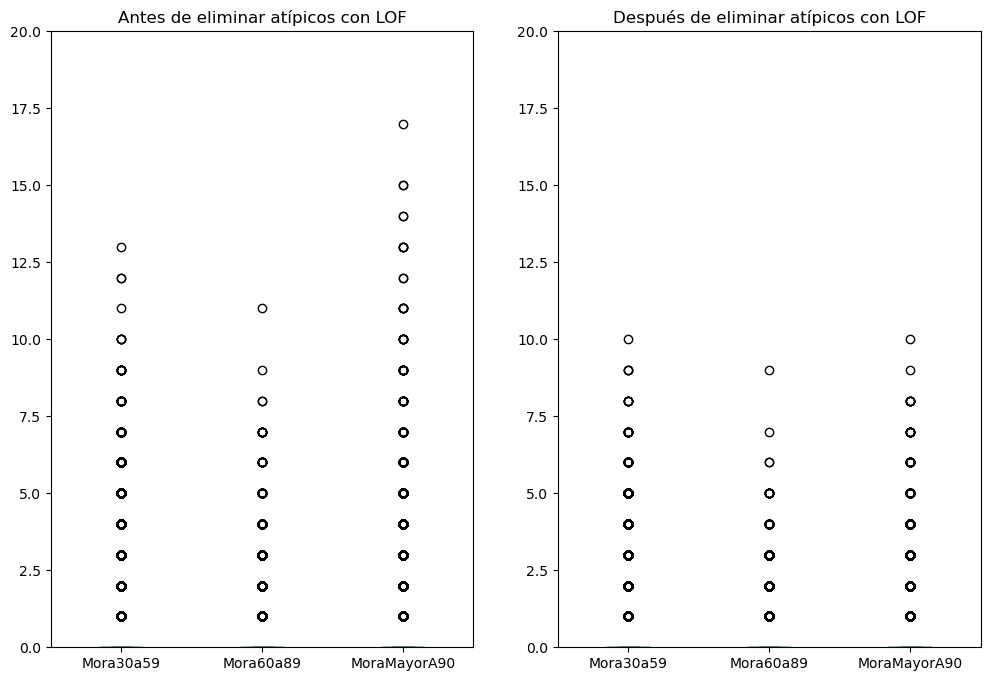

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
sns.boxplot = d.boxplot(column=['Mora30a59dias', 'Mora60a89dias', 'MoraMayorA90'],ax=ax[0],grid=False)  
ax[0].set_title('Antes de eliminar atípicos con LOF')
ax[0].set_ylim(0,20)
sns.boxplot = df.boxplot(column=['Mora30a59dias', 'Mora60a89dias', 'MoraMayorA90'],ax=ax[1],grid=False)  
ax[1].set_title('Después de eliminar atípicos con LOF')
ax[1].set_ylim(0,20)

Considero que no debemos eliminar atípicos, al menos no en estas variables temporales

Incumplimiento             Axes(0.125,0.11;0.0545775x0.77)
Cupos                   Axes(0.190493,0.11;0.0545775x0.77)
Edad                    Axes(0.255986,0.11;0.0545775x0.77)
Mora30a59               Axes(0.321479,0.11;0.0545775x0.77)
RatioDeuda              Axes(0.386972,0.11;0.0545775x0.77)
IngresoMensual          Axes(0.452465,0.11;0.0545775x0.77)
LineasCredito           Axes(0.517958,0.11;0.0545775x0.77)
MoraMayorA90            Axes(0.583451,0.11;0.0545775x0.77)
CreditosHipotecarios    Axes(0.648944,0.11;0.0545775x0.77)
Mora60a89               Axes(0.714437,0.11;0.0545775x0.77)
Dependientes             Axes(0.77993,0.11;0.0545775x0.77)
OcurrenciasMora         Axes(0.845423,0.11;0.0545775x0.77)
dtype: object

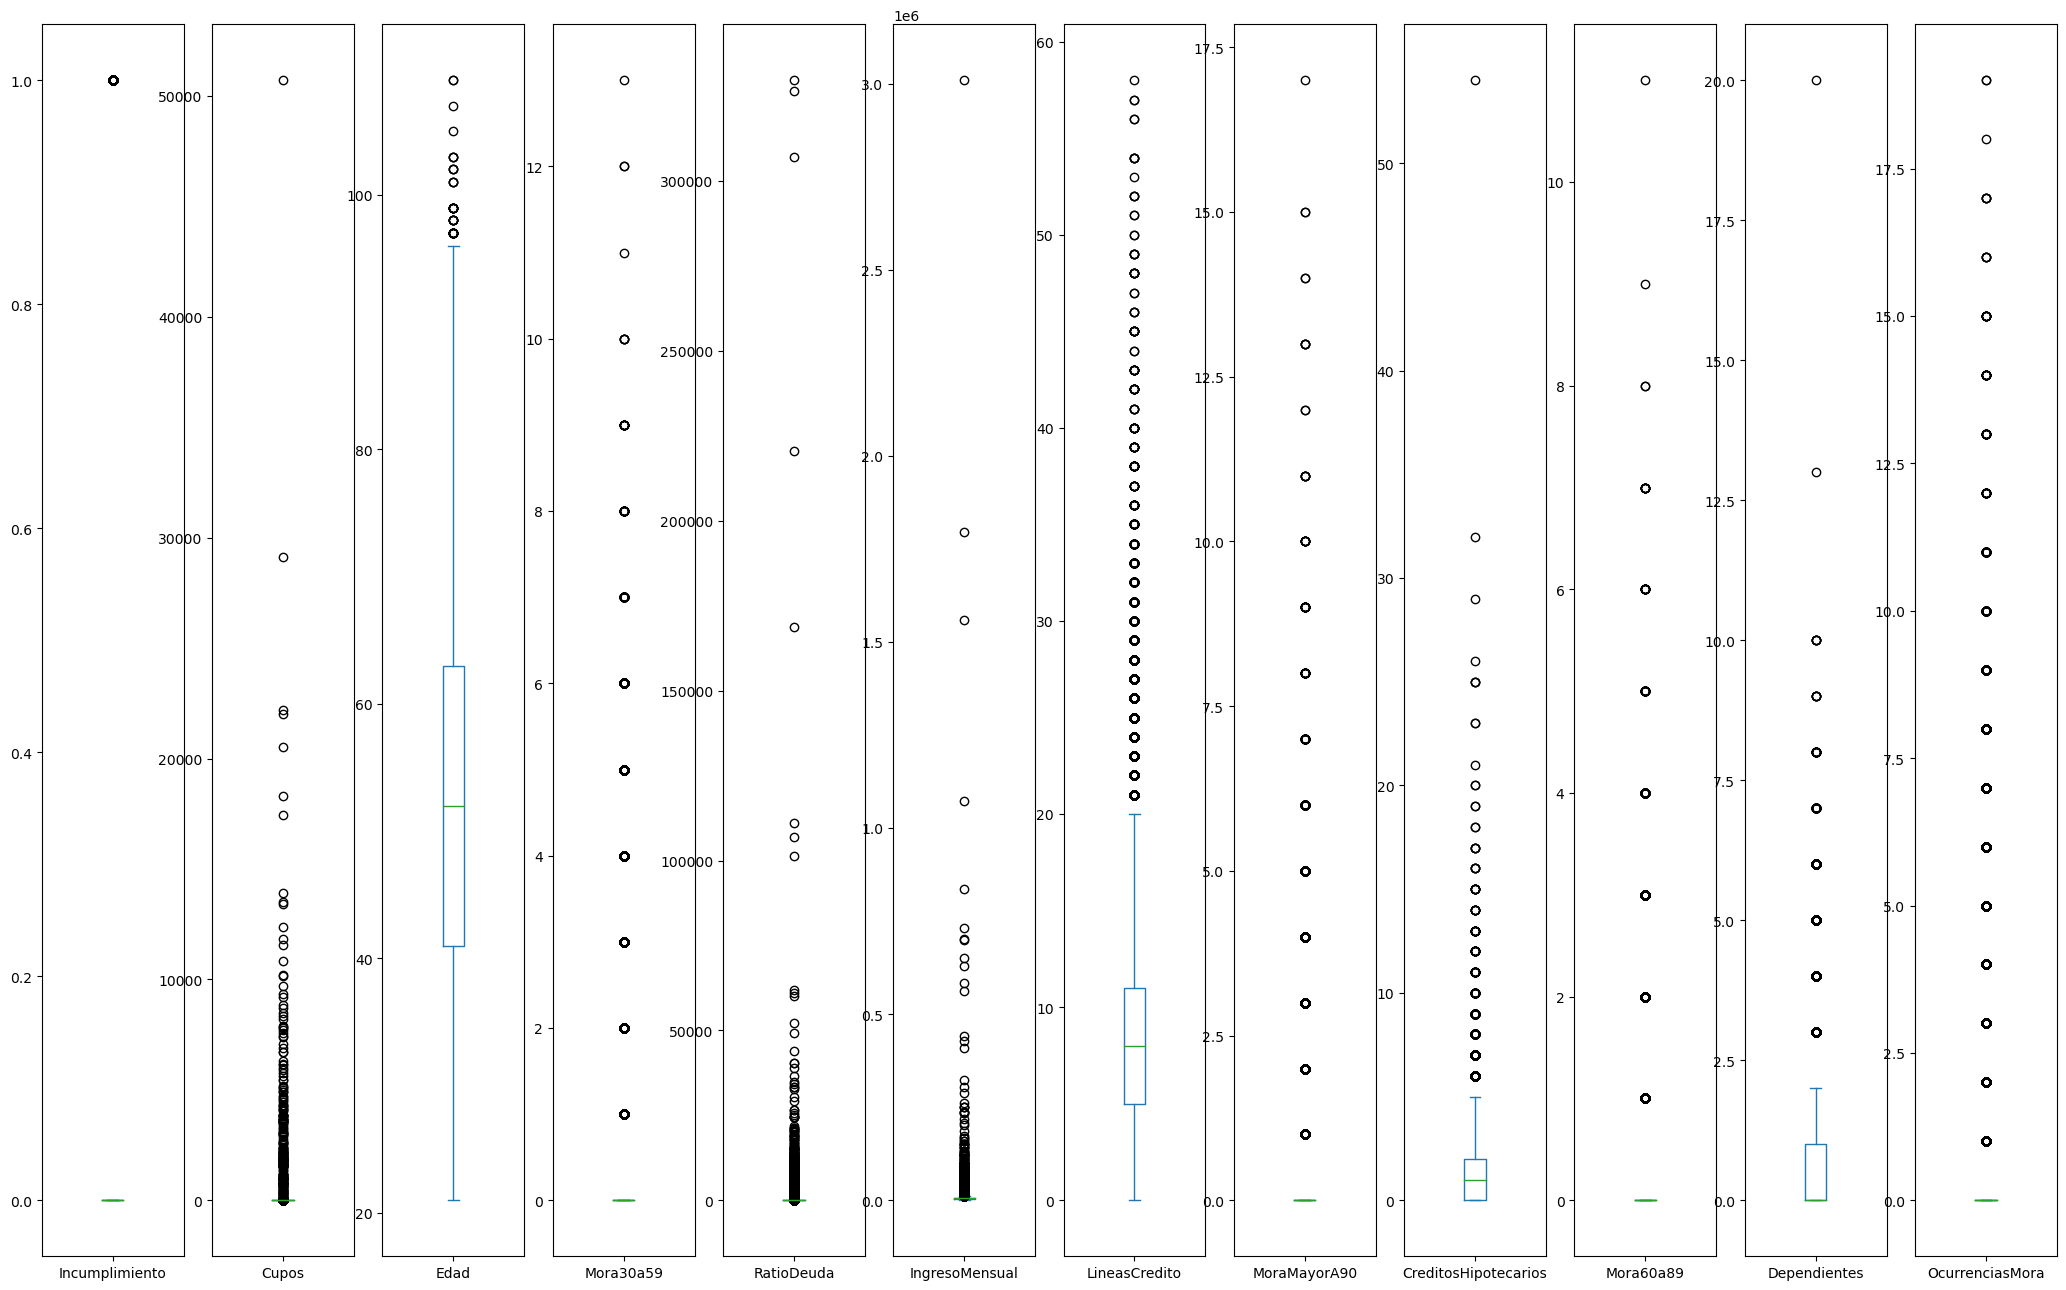

In [23]:
d.plot(kind='box',subplots=True, sharey=False, figsize=(26, 16))

Incumplimiento             Axes(0.125,0.11;0.0545775x0.77)
Cupos                   Axes(0.190493,0.11;0.0545775x0.77)
Edad                    Axes(0.255986,0.11;0.0545775x0.77)
Mora30a59               Axes(0.321479,0.11;0.0545775x0.77)
RatioDeuda              Axes(0.386972,0.11;0.0545775x0.77)
IngresoMensual          Axes(0.452465,0.11;0.0545775x0.77)
LineasCredito           Axes(0.517958,0.11;0.0545775x0.77)
MoraMayorA90            Axes(0.583451,0.11;0.0545775x0.77)
CreditosHipotecarios    Axes(0.648944,0.11;0.0545775x0.77)
Mora60a89               Axes(0.714437,0.11;0.0545775x0.77)
Dependientes             Axes(0.77993,0.11;0.0545775x0.77)
OcurrenciasMora         Axes(0.845423,0.11;0.0545775x0.77)
dtype: object

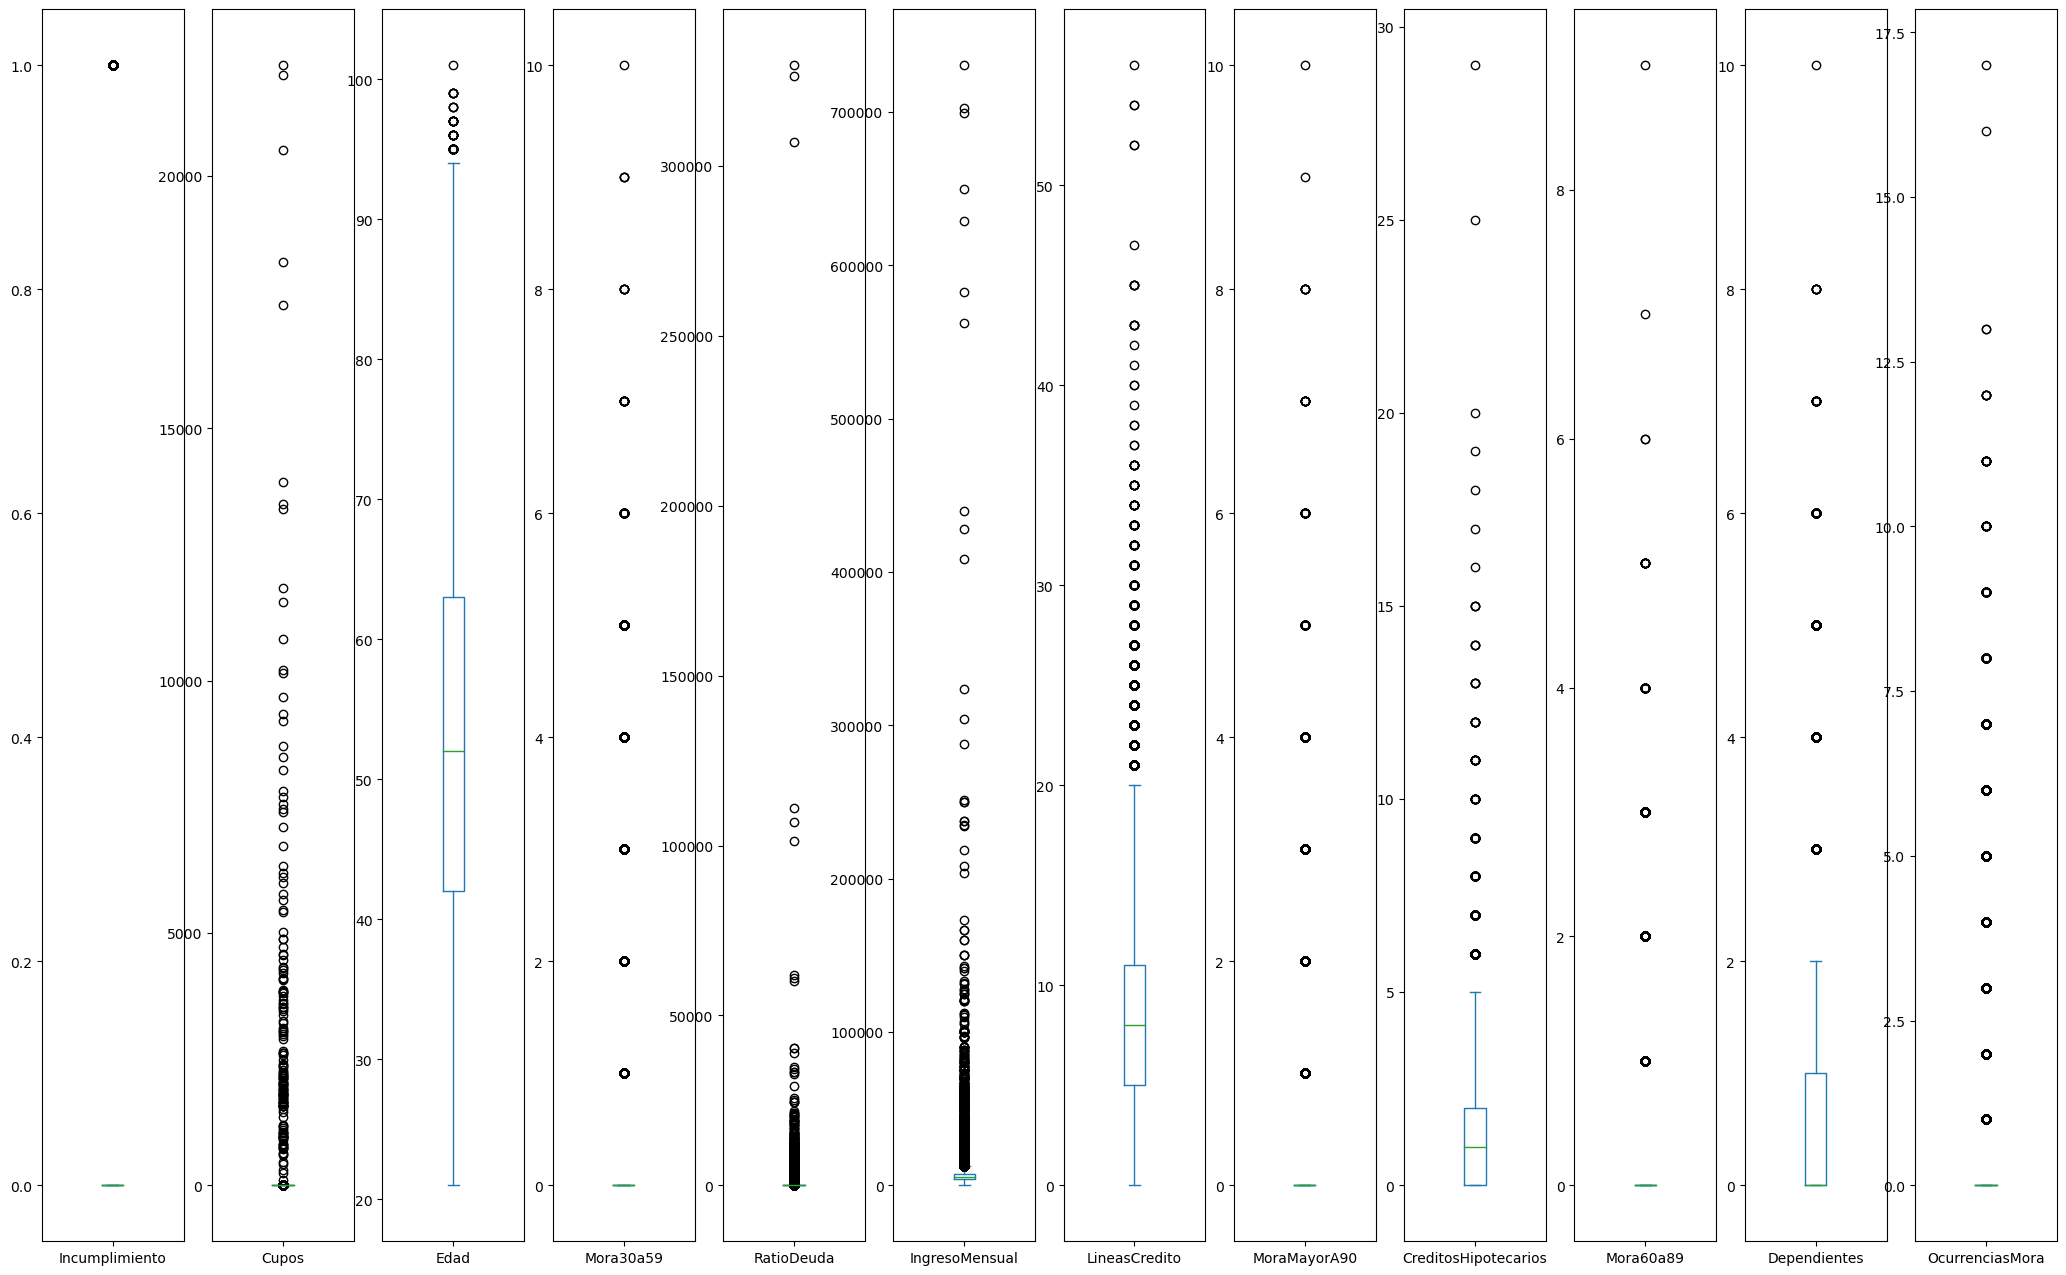

In [24]:
df.plot(kind='box',subplots=True, sharey=False, figsize=(26, 16))


In [25]:
df.describe()

,Incumplimiento,Cupos,Edad,Mora30a59,RatioDeuda,IngresoMensual,LineasCredito,MoraMayorA90,CreditosHipotecarios,Mora60a89,Dependientes,OcurrenciasMora
count,134630.000000,134630.000000,134630.000000,134630.000000,134630.000000,134630.000000,134630.000000,134630.000000,134630.000000,134630.000000,134630.000000,134630.000000
mean,0.056845,5.039707,52.317388,0.207836,359.085948,6329.610221,8.334695,0.065104,1.001575,0.050152,0.721697,0.323093
std,0.231546,195.498849,14.516912,0.596269,1964.352269,7583.338502,4.828028,0.356584,1.042030,0.268135,1.075041,0.885274
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.028933,42.000000,0.000000,0.179084,3953.250000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.144985,52.000000,0.000000,0.368059,5400.000000,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,0.528447,63.000000,0.000000,0.885140,7333.000000,11.000000,0.000000,2.000000,0.000000,1.000000,0.000000
max,1.000000,22198.000000,101.000000,10.000000,329664.000000,730483.000000,56.000000,10.000000,29.000000,9.000000,10.000000,17.000000


In [25]:
# Exportar df a csv
nombre_archivo = 'data/Preprocessed.csv'

df.to_csv(nombre_archivo, index=False)